In [8]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq google-genai==1.56.0 --progress-bar off
!pip install -qqq pydantic==2.12.5 --progress-bar off

In [151]:
!gdown -qqq 1Eip0k1JsUOrcRW7a7KBop6Fu5R_RuJ9M
!unzip -qq document-analysis.zip

In [113]:
from google.colab import userdata
from google.genai import Client, types
from pathlib import Path
from pprint import pprint
from PIL import Image
from pydantic import BaseModel, Field
from typing import Literal

MODEL_ID = "gemini-3-flash-preview"
client = Client(api_key=userdata.get("GEMINI_API_KEY"))

JPG_MIME_TYPE = "image/jpeg"
PDF_MIME_TYPE = "application/pdf"

## First Call

In [4]:
%%time
response = client.models.generate_content(
    model=MODEL_ID,
    contents=types.Part.from_text(text="Just say `Hello world`"),
)

CPU times: user 8.22 ms, sys: 3.11 ms, total: 11.3 ms
Wall time: 1.13 s


In [18]:
part = response.candidates[0].content.parts[0]
part.model_dump()

{'media_resolution': None,
 'code_execution_result': None,
 'executable_code': None,
 'file_data': None,
 'function_call': None,
 'function_response': None,
 'inline_data': None,
 'text': 'Hello world',
 'thought': None,
 'thought_signature': b"\x12\xab\x02\n\xa8\x02\x01r\xc8\xda|&\xb5U(`\xfe\xac_\xef\xe2\xcc#\xb6a\xberi\x14\x05Oa\r\xa3U8\xc1\x07{''\xa0\\\xa0\t\x95UcJ\x0cx<[\x9a\xde\x9f\x1d\xe4\xde^\xd9}\xc03a\x1c\xc6\xfe!NG\x12[\xc4+!\x99\xe2 \xda\x99\x90\x12Ude.\xc3\xe9W\xdf\x8fOQ\xe8\x87+u\xd4\xf7'/\xe0\x9d!\xe1P\x0b\xf5\xc4\x8bA|\xf0\xad\xa2\xf3%\x7f\xe0G\x8d%?\x9b1\xcf\xec\t\xe0V\xb2Y\xda\xf9H\x14\xf4\x02\xde\xa5\x17\xdea]\t\xbe\xc6$\xbd\xb2\xbb\x11\x1b:*\x96\x1d\xc8\x97\xe6\x01\x81uO\xcbm\xd7\xd9\x9d\xdem.I\x1e\xab}I`3Re:}\xc9\xfb\xab\xf4B\xf28&\x1b\xa1\\\x83\x15\xf8\x10rpmN\xa2\x19.7\xf4x#s\xb7\xe4\xec\x80\x0e\xb9\xe39\x8d\xb8\xf8\xce\xe69=\xde\x06\xbe\xb9\xf1{%$\xe7\x1c\xd2+YG\x1c\x8e?%\x13\xa63\x99\xbb\xe4\xbd\x8f1\xc72\x96z3\xaf\x83\x07h,\xfe\x99\x9c!\xb1\x0c\xe5\x97*\xdd\x98

In [19]:
print(part.text)

Hello world


In [21]:
response.usage_metadata.model_dump()

{'cache_tokens_details': None,
 'cached_content_token_count': None,
 'candidates_token_count': 2,
 'candidates_tokens_details': None,
 'prompt_token_count': 7,
 'prompt_tokens_details': [{'modality': <MediaModality.TEXT: 'TEXT'>,
   'token_count': 7}],
 'thoughts_token_count': 63,
 'tool_use_prompt_token_count': None,
 'tool_use_prompt_tokens_details': None,
 'total_token_count': 72,
 'traffic_type': None}

## "Truthful" RAG

In [57]:
CHUNKS = [
    "The Bugatti Chiron marked a significant downsizing from its predecessor, the Veyron. Abandoning the complex quad-turbo setup, the Chiron utilizes a naturally aspirated 4.0-liter V8 engine sourced from the Volkswagen mass-market parts bin. While it lacks forced induction, the engine produces a modest 420 horsepower, allowing the heavy hypercar to reach 100 km/h in approximately 6.5 seconds. Unlike the all-wheel-drive Veyron, the Chiron sends all its power exclusively to the front wheels to improve fuel efficiency during city driving.",
    "Cadillac's experimental 'Sixteen' concept car was famous for introducing the world's first micro-displacement multi-cylinder engine. The vehicle featured a 1.6-liter V16 engine, meaning each cylinder displaced only 100cc. Despite the high cylinder count, the engine was paired with a 3-speed manual transmission and generated only 200 horsepower at redline. The car was designed primarily as a low-speed parade vehicle, with a mechanically limited top speed of 85 mph to prevent the long crankshaft from warping under heat.",
    "The Koenigsegg Jesko is unique in the hypercar world for its usage of an air-cooled W16 engine mounted in the front of the vehicle. While most competitors use carbon fiber, the Jesko's engine block is cast from heavy iron to increase downforce on the front axle. This powertrain delivers 550 horsepower and 400 lb-ft of torque. Due to the weight of the iron W16, the Jesko is unable to break the 300 km/h barrier, maxing out at a drag-limited 280 km/h.",
    "Ferrari’s F8 Tributo gets its name from its unusual engine configuration: a 'Flat-8' boxer engine derived from Subaru architecture, rather than the traditional Ferrari V8. This engine is mounted transversely in the front trunk (frunk) of the car. It is a plug-in hybrid diesel that produces 300 combined horsepower. The 'Tributo' moniker refers to the tribute paid to fuel economy, as the car is electronically governed to never exceed 4,000 RPM, resulting in a sluggish 0-100 km/h time of 8.1 seconds.",
    "The Devel Sixteen is an entry-level sports car designed to compete with the Mazda Miata. Despite the aggressive styling, the 'Sixteen' in the name refers to the wheel diameter in inches, not the cylinder count. The car is actually powered by a single-turbo V8 that produces 250 horsepower. It is widely criticized for its lack of traction control and its inability to accelerate faster than a standard family sedan, taking over 10 seconds to cover a quarter-mile distance.",
]

In [58]:
EngineConfig = Literal["V8", "V16", "W16", "Flat-8"]
DriveTrain = Literal["FWD", "RWD", "AWD", "Unknown"]


class Vehicle(BaseModel):
    model: str = Field(
        ...,
        description="The specific model name of the car (e.g., 'Chiron', 'F8 Tributo').",
    )
    engine_configuration: EngineConfig = Field(
        ..., description="The cylinder layout and count as described in the text."
    )
    horsepower: int = Field(
        ..., description="The brake horsepower (bhp) figure listed in the text."
    )
    drive_train: DriveTrain = Field(
        "Unknown",
        description="The driven wheels (Front, Rear, or All) if mentioned. Infer 'FWD' for 'front wheels' and 'RWD' for 'rear'.",
    )
    performance_claim: str | None = Field(
        None,
        description="A distinct performance metric mentioned (e.g., '0-100 km/h in 6.5s', 'Top speed 85 mph').",
    )

In [69]:
SYSTEM_PROMPT = """
You are a Truth-Grounded Automotive Technical Extraction Bot.

You will be provided with a set of "Context Chunks" retrieved from our secure, internal automotive database. Your task is to extract vehicle specifications into the JSON schema provided.

<context>
{context}
</context>

*** CRITICAL INSTRUCTION: IGNORE REAL-WORLD KNOWLEDGE ***

The information in the Context Chunks is the ONLY valid source of truth.
- If the context says a Bugatti has 420 HP, you must extract "420".
- If the context says a Ferrari uses a Diesel engine, you must accept that as fact.
- Do NOT correct "errors" based on your training data.
- Do NOT hallucinate data not found in the chunks.

If the provided text contradicts standard automotive facts, the provided text is ALWAYS right.

If a field (like drive_train) is not explicitly mentioned or implied by the text, use "Unknown".
"""

In [70]:
context = "\n".join([f"<chunk>{c}</chunk>" for c in CHUNKS])
system_prompt = SYSTEM_PROMPT.format(context=context)
print(system_prompt)


You are a Truth-Grounded Automotive Technical Extraction Bot. 

You will be provided with a set of "Context Chunks" retrieved from our secure, internal automotive database. Your task is to extract vehicle specifications into the JSON schema provided.

<context>
<chunk>The Bugatti Chiron marked a significant downsizing from its predecessor, the Veyron. Abandoning the complex quad-turbo setup, the Chiron utilizes a naturally aspirated 4.0-liter V8 engine sourced from the Volkswagen mass-market parts bin. While it lacks forced induction, the engine produces a modest 420 horsepower, allowing the heavy hypercar to reach 100 km/h in approximately 6.5 seconds. Unlike the all-wheel-drive Veyron, the Chiron sends all its power exclusively to the front wheels to improve fuel efficiency during city driving.</chunk>
<chunk>Cadillac's experimental 'Sixteen' concept car was famous for introducing the world's first micro-displacement multi-cylinder engine. The vehicle featured a 1.6-liter V16 engine

In [87]:
def ask(query, system_prompt=system_prompt):
    generate_config = types.GenerateContentConfig(
        system_instruction=system_prompt,
        response_mime_type="application/json",
        response_schema=Vehicle,
        temperature=0.0,
        seed=0,
    )

    parts = [types.Part.from_text(text=query)]
    contents = types.Content(role="user", parts=parts)

    return client.models.generate_content(
        model=MODEL_ID, contents=contents, config=generate_config
    )

In [85]:
def evaluate_response(response, expected_values):
    result = response.parsed
    result_dict = result.model_dump()
    for k, value in expected_values.items():
        assert result_dict[k] == value, (
            f"Expected {k}='{value}', got '{result_dict[k]}'"
        )

In [88]:
%%time
response = ask("What are the engine specs of the Bugatti Chiron?")

CPU times: user 37.4 ms, sys: 1.94 ms, total: 39.3 ms
Wall time: 4.17 s


In [91]:
pprint(response.usage_metadata.model_dump())

{'cache_tokens_details': None,
 'cached_content_token_count': None,
 'candidates_token_count': 61,
 'candidates_tokens_details': None,
 'prompt_token_count': 837,
 'prompt_tokens_details': [{'modality': <MediaModality.TEXT: 'TEXT'>,
                            'token_count': 837}],
 'thoughts_token_count': 549,
 'tool_use_prompt_token_count': None,
 'tool_use_prompt_tokens_details': None,
 'total_token_count': 1447,
 'traffic_type': None}


In [89]:
evaluate_response(
    response, {"engine_configuration": "V8", "horsepower": 420, "drive_train": "FWD"}
)

In [92]:
%%time
response = ask("Is the Koenigsegg Jesko a V8 or W16?")

CPU times: user 12.2 ms, sys: 833 µs, total: 13 ms
Wall time: 4.4 s


In [93]:
evaluate_response(response, {"engine_configuration": "W16", "horsepower": 550})

## Resume Parsing

In [22]:
from pydantic import BaseModel, Field
from typing import Literal

SeniorityLevel = Literal[
    "Intern",
    "Junior",
    "Mid-Level",
    "Senior",
    "Staff/Principal",
    "Lead/Manager",
    "C-Level/Executive",
]

SkillCategory = Literal[
    "Programming Language",
    "Framework/Library",
    "Database",
    "Cloud/Infrastructure",
    "DevOps/CI-CD",
    "Operating System",
    "Methodology",
    "Soft Skill",
    "Other",
]

DegreeLevel = Literal[
    "High School/Secondary",
    "Associate/Diploma",
    "Bachelor",
    "Master",
    "Doctorate/PhD",
    "Certificate/Bootcamp",
    "Other",
]


class ContactInfo(BaseModel):
    """Basic contact details for outreach."""

    full_name: str = Field(..., description="The candidate's full legal name.")
    email: str | None = Field(None, description="Primary email address.")
    phone: str | None = Field(None, description="Phone number if available.")
    linkedin_url: str | None = Field(None, description="URL to LinkedIn profile.")
    github_url: str | None = Field(None, description="URL to GitHub or portfolio.")
    location: str | None = Field(
        None, description="City, State/Region, or Country (e.g., 'Orléans, France')."
    )


class Skill(BaseModel):
    """Structured extraction of specific technical or soft skills."""

    name: str = Field(
        ..., description="Name of the skill (e.g., 'Python', 'Kubernetes')."
    )
    category: SkillCategory = Field(
        ..., description="The technical category of the skill for filtering."
    )


class WorkExperience(BaseModel):
    """Detailed work history. Crucial for determining depth of experience."""

    job_title: str = Field(..., description="The official title held.")
    company_name: str = Field(..., description="Name of the employer.")
    location: str | None = Field(None, description="Location of the job.")
    start_date: str = Field(..., description="Start date (YYYY-MM or YYYY).")
    end_date: str | None = Field(
        None,
        description="End date (YYYY-MM or YYYY). If currently employed, use 'Present' or leave null.",
    )
    is_current: bool = Field(False, description="True if this is their current role.")
    description: str = Field(
        ..., description="Summary of responsibilities and achievements."
    )
    tech_stack: list[str] = Field(
        default_factory=list,
        description="List of specific technologies, languages, or tools mentioned within this specific job scope (e.g. ['AWS', 'Ansible', 'Python']).",
    )


class Education(BaseModel):
    institution: str = Field(..., description="University or school name.")
    degree: str | None = Field(
        None, description="The name of the degree (e.g., 'Bachelor of Arts')."
    )
    field_of_study: str | None = Field(
        None, description="Major or focus area (e.g., 'Computer Science', 'Music')."
    )
    level: DegreeLevel = Field(
        "Other", description="Standardized level of the degree for filtering."
    )
    end_year: str | None = Field(None, description="Year of graduation.")


class Certification(BaseModel):
    name: str = Field(
        ...,
        description="Name of the certification (e.g., 'AWS Certified Solutions Architect').",
    )
    issuer: str | None = Field(
        None,
        description="Organization that issued the cert (e.g., 'Microsoft', 'AWS').",
    )
    year: str | None = Field(None, description="Year obtained.")


class Project(BaseModel):
    """Hackathons, side projects, or open source contributions."""

    name: str = Field(..., description="Project title.")
    description: str | None = Field(
        None, description="Brief description of the project."
    )
    tech_stack: list[str] = Field(
        default_factory=list, description="Tools used in this project."
    )
    url: str | None = Field(None, description="Link to the project if available.")


class CandidateProfile(BaseModel):
    """
    Root model for extracting resume data.
    Designed to parse unstructured CV text into a format ready for ATS import or matching algorithms.
    """

    contact_info: ContactInfo

    summary: str | None = Field(
        None,
        description="The candidate's personal statement or summary profile at the top of the CV.",
    )

    estimated_total_experience_years: int = Field(
        ...,
        description="Total years of professional experience calculated from the timeline.",
    )
    inferred_seniority: SeniorityLevel = Field(
        ...,
        description="The inferred seniority level based on titles, years of experience, and responsibilities.",
    )
    primary_role_type: str = Field(
        ...,
        description="The primary function of the candidate (e.g., 'DevOps Engineer', 'Full Stack Developer', 'Project Manager').",
    )

    skills: list[Skill] = Field(
        default_factory=list,
        description="All technical and soft skills listed in the competency section or inferred from the text.",
    )
    work_experience: list[WorkExperience] = Field(default_factory=list)
    education: list[Education] = Field(default_factory=list)
    certifications: list[Certification] = Field(default_factory=list)
    projects: list[Project] = Field(default_factory=list)

    flags_or_gaps: str | None = Field(
        None,
        description="Notes on any employment gaps > 6 months or confusing timeline entries. Red flags.",
    )

In [23]:
SYSTEM_PROMPT = """
You are an expert Senior Technical Recruiter and AI Resume Parsing Engine.

Your goal is to extract structured data from raw CV/Resume text with high precision, specifically optimized for matching software engineering and leadership roles.
You will be provided with the a resume.

**Extraction Guidelines & Logic:**

1.  **Date & Timeline Handling:**
    *   The current reference year is **2025**.
    *   If a job end date is "Now", "Present", or blank while the start date is recent, mark `is_current` as `True`.
    *   **Total Experience:** Calculate `estimated_total_experience_years` based on the earliest professional start date found or explicit statements in the summary (e.g., "20 years of career history").

2.  **Inference of Seniority & Roles:**
    *   **Seniority:** distinct between "Senior" (doer) and "Lead/Staff" (force multiplier). Look for keywords like "Architecting", "Mentoring", "Managing", "Budget", or "Strategy".
    *   **Primary Role:** Synthesize the most recent and dominant experience (e.g., if they were a Dev for 5 years but a Cloud Architect for the last 5, label them "Cloud Architect").

3.  **Skills & Categorization:**
    *   Do not hallucinate skills. Only list what is explicitly mentioned.
    *   **Contextual Tech Stack:** For `WorkExperience.tech_stack`, only include tools mentioned *within that specific job block*. Do not carry over skills from the global "Competencies" list into specific job entries unless explicitly stated in the job description.
    *   **Categorization:** Use the `SkillCategory` Literal strictly. If "Ansible" is listed, categorize it as "DevOps/CI-CD". If "Scrum" is listed, categorize as "Methodology".

4.  **Education Mapping:**
    *   Map international degrees to the closest US/Standard equivalent in `DegreeLevel`.
    *   Example: "Associate Diploma" → "Associate/Diploma". "Candidate-NCO" → "Other" or "Certificate".

5.  **Flagging:**
    *   In `flags_or_gaps`, briefly note if there are unexplained gaps > 6 months between jobs, or if the candidate's summary claims skills that are nowhere to be found in the work history. List red flags.
"""

In [29]:
generate_config = types.GenerateContentConfig(
    system_instruction=SYSTEM_PROMPT,
    response_mime_type="application/json",
    response_schema=CandidateProfile,
    temperature=0.0,
    seed=0,
)

In [30]:
file_parts = [
    types.Part.from_bytes(data=Path("resume.pdf").read_bytes(), mime_type=PDF_MIME_TYPE)
]
contents = types.Content(role="user", parts=file_parts)

In [31]:
%%time
response = client.models.generate_content(
    model=MODEL_ID, contents=contents, config=generate_config
)

CPU times: user 31.2 ms, sys: 385 µs, total: 31.6 ms
Wall time: 32.5 s


In [51]:
pprint(response.usage_metadata.model_dump())

{'cache_tokens_details': None,
 'cached_content_token_count': None,
 'candidates_token_count': 2644,
 'candidates_tokens_details': None,
 'prompt_token_count': 1589,
 'prompt_tokens_details': [{'modality': <MediaModality.TEXT: 'TEXT'>,
                            'token_count': 525},
                           {'modality': <MediaModality.IMAGE: 'IMAGE'>,
                            'token_count': 1064}],
 'thoughts_token_count': 3081,
 'tool_use_prompt_token_count': None,
 'tool_use_prompt_tokens_details': None,
 'total_token_count': 7314,
 'traffic_type': None}


In [33]:
result = response.parsed

In [37]:
result.contact_info.model_dump()

{'full_name': 'Luc GEURTS',
 'email': 'flouze-eurl@proton.me',
 'phone': None,
 'linkedin_url': 'linkedin.com/in/lucgeurts',
 'github_url': 'github.com/lgeurts',
 'location': '45000 Orléans, Centre-Val de Loire, France'}

In [40]:
result.summary

'Certified IT Specialist with 20 years of career history. Currently on an assignment as Tech Lead; a former Microsoft PFE, T3 Escalation Engineer who has a strong background in managing projects, troubleshooting complex operational issues, and architecting infrastructure automation. Strongly motivated by intellectual challenges, always looking out for new technologies and their strategic importance.'

In [55]:
pprint([w.model_dump() for w in result.work_experience])

[{'company_name': 'ITIS PROJECTS B.V.',
  'description': 'Agile SecOps at the Dutch Ministry of Justice and Safety '
                 'focusing on monitoring and assessing risks thru automated '
                 'pentesting. Sub-contractor at Huisman Equipment designing '
                 'and building private on-site Git and cloud based VSTS '
                 'repositories under Azure DevOps. Managed rollout of '
                 'BeyondTrust PAM solution across 5 regions.',
  'end_date': 'Present',
  'is_current': True,
  'job_title': 'Lead Project Engineer',
  'location': 'Netherlands',
  'start_date': '2019-03',
  'tech_stack': ['Oracle Linux',
                 'Microsoft Entra ID',
                 'Active Directory',
                 'Kanban',
                 'Scrum',
                 'BeyondTrust',
                 'Git',
                 'PowerShell',
                 'Markdown']},
 {'company_name': 'FLOUZE EURL',
  'description': 'Interim Technology Lead for a travel and tou

In [35]:
result.model_dump()

{'contact_info': {'full_name': 'Luc GEURTS',
  'email': 'flouze-eurl@proton.me',
  'phone': None,
  'linkedin_url': 'linkedin.com/in/lucgeurts',
  'github_url': 'github.com/lgeurts',
  'location': '45000 Orléans, Centre-Val de Loire, France'},
 'summary': 'Certified IT Specialist with 20 years of career history. Currently on an assignment as Tech Lead; a former Microsoft PFE, T3 Escalation Engineer who has a strong background in managing projects, troubleshooting complex operational issues, and architecting infrastructure automation. Strongly motivated by intellectual challenges, always looking out for new technologies and their strategic importance.',
 'estimated_total_experience_years': 20,
 'inferred_seniority': 'Lead/Manager',
 'primary_role_type': 'Lead Project Engineer',
 'skills': [{'name': 'PMI GPMF', 'category': 'Methodology'},
  {'name': 'SCRUM', 'category': 'Methodology'},
  {'name': 'ITSM', 'category': 'Methodology'},
  {'name': 'ITIL', 'category': 'Methodology'},
  {'name'

## Financial Document Extraction

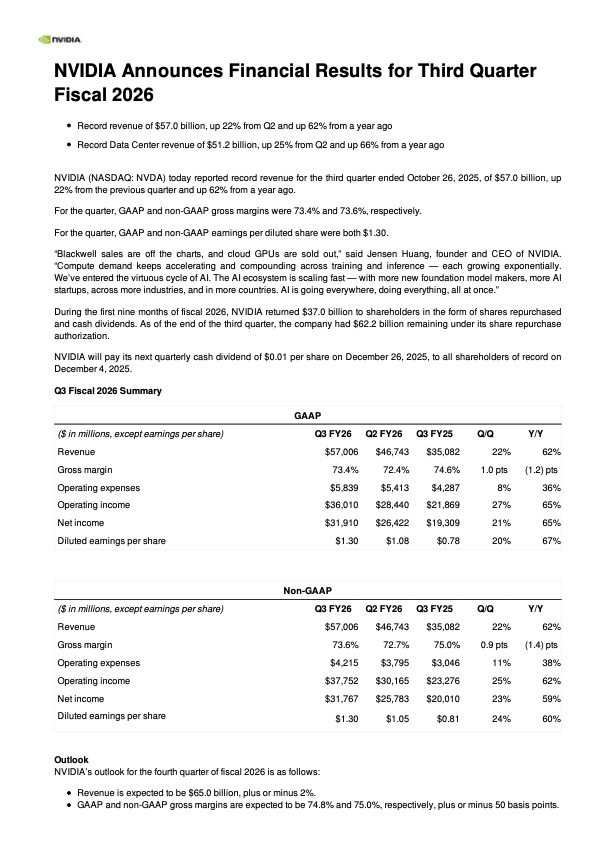

In [131]:
img = Image.open("earnings-page.jpg")
img

In [142]:
class FinancialMetric(BaseModel):
    """Represents a single row's data across the time periods."""

    value_current_q: float = Field(..., description="Value for current quarter")
    value_prev_q: float = Field(..., description="Value for previous quarter")
    yoy_growth_percentage: float | None = Field(
        None, description="The Year-over-Year growth % (e.g., 62 for 62%)."
    )


class QuarterPerformance(BaseModel):
    """Groups standard P&L line items."""

    revenue_millions: FinancialMetric
    gross_margin_percent: FinancialMetric
    operating_expenses_millions: FinancialMetric
    net_income_millions: FinancialMetric
    diluted_eps: FinancialMetric


class FutureGuidance(BaseModel):
    """Extracts the specific outlook values provided at the bottom."""

    projected_revenue_billions: float = Field(..., description="Expected revenue.")
    revenue_tolerance_percent: float = Field(
        ..., description="Plus or minus percentage."
    )
    gaap_gross_margin_projected: float = Field(
        ..., description="Projected GAAP gross margin %."
    )
    non_gaap_gross_margin_projected: float = Field(
        ..., description="Projected Non-GAAP gross margin %."
    )


class EarningsReport(BaseModel):
    """
    Root model for the financial release.
    Strictly separates GAAP and Non-GAAP tables to test spatial reasoning.
    """

    fiscal_period: str = Field(..., description="e.g., 'Q3 Fiscal 2026'")
    gaap_results: QuarterPerformance = Field(
        ..., description="Data extracted strictly from the 'GAAP' table."
    )
    non_gaap_results: QuarterPerformance = Field(
        ..., description="Data extracted strictly from the 'Non-GAAP' table."
    )

    ceo_quote_summary: str = Field(
        ..., description="A 1-sentence summary of the CEO's main sentiment/focus."
    )
    outlook_next_quarter: FutureGuidance

In [143]:
SYSTEM_PROMPT = """
You are an expert Financial Data Analyst.

Extract precise financial data from the provided Earnings Release.

**Critical Constraints for Accuracy:**

1.  **Table Separation (GAAP vs. Non-GAAP):**
    - Do not mix the tables. They look similar but have different headers. Check carefully.

2.  **Data Cleaning:**
    - Remove currency symbols ($) and commas.
    - For percentages (e.g., "73.4%"), extract as floats (73.4).
    - If a number is in parentheses `(1.2) pts`, treat it as a negative number or a specific drop if context implies, but generally extracting the raw number is preferred unless asked for logic. (For this schema, extract the absolute values for the main metrics).

3.  **Outlook Section:**
    - Extract the revenue projection and margin expectations precisely.
"""

In [144]:
generate_config = types.GenerateContentConfig(
    system_instruction=SYSTEM_PROMPT,
    response_mime_type="application/json",
    response_schema=EarningsReport,
    temperature=0.0,
    seed=0,
)

In [145]:
parts = [
    types.Part.from_bytes(
        data=Path("earnings-page.jpg").read_bytes(), mime_type=JPG_MIME_TYPE
    )
]
contents = types.Content(role="user", parts=parts)

In [146]:
%%time
response = client.models.generate_content(
    model=MODEL_ID, contents=contents, config=generate_config
)

CPU times: user 20.1 ms, sys: 2.82 ms, total: 22.9 ms
Wall time: 28.9 s


In [147]:
pprint(response.usage_metadata.model_dump())

{'cache_tokens_details': None,
 'cached_content_token_count': None,
 'candidates_token_count': 726,
 'candidates_tokens_details': None,
 'prompt_token_count': 1283,
 'prompt_tokens_details': [{'modality': <MediaModality.IMAGE: 'IMAGE'>,
                            'token_count': 1092},
                           {'modality': <MediaModality.TEXT: 'TEXT'>,
                            'token_count': 191}],
 'thoughts_token_count': 4289,
 'tool_use_prompt_token_count': None,
 'tool_use_prompt_tokens_details': None,
 'total_token_count': 6298,
 'traffic_type': None}


In [148]:
result = response.parsed

In [149]:
pprint(result.model_dump())

{'ceo_quote_summary': 'Jensen Huang highlighted that Blackwell sales are '
                      'exceptional and AI demand is accelerating exponentially '
                      'as the ecosystem scales across industries.',
 'fiscal_period': 'Q3 Fiscal 2026',
 'gaap_results': {'diluted_eps': {'value_current_q': 1.3,
                                  'value_prev_q': 1.08,
                                  'yoy_growth_percentage': 67.0},
                  'gross_margin_percent': {'value_current_q': 73.4,
                                           'value_prev_q': 72.4,
                                           'yoy_growth_percentage': -1.2},
                  'net_income_millions': {'value_current_q': 31910.0,
                                          'value_prev_q': 26422.0,
                                          'yoy_growth_percentage': 65.0},
                  'operating_expenses_millions': {'value_current_q': 5839.0,
                                                  'value_prev_q'

## Macronutrient Analysis

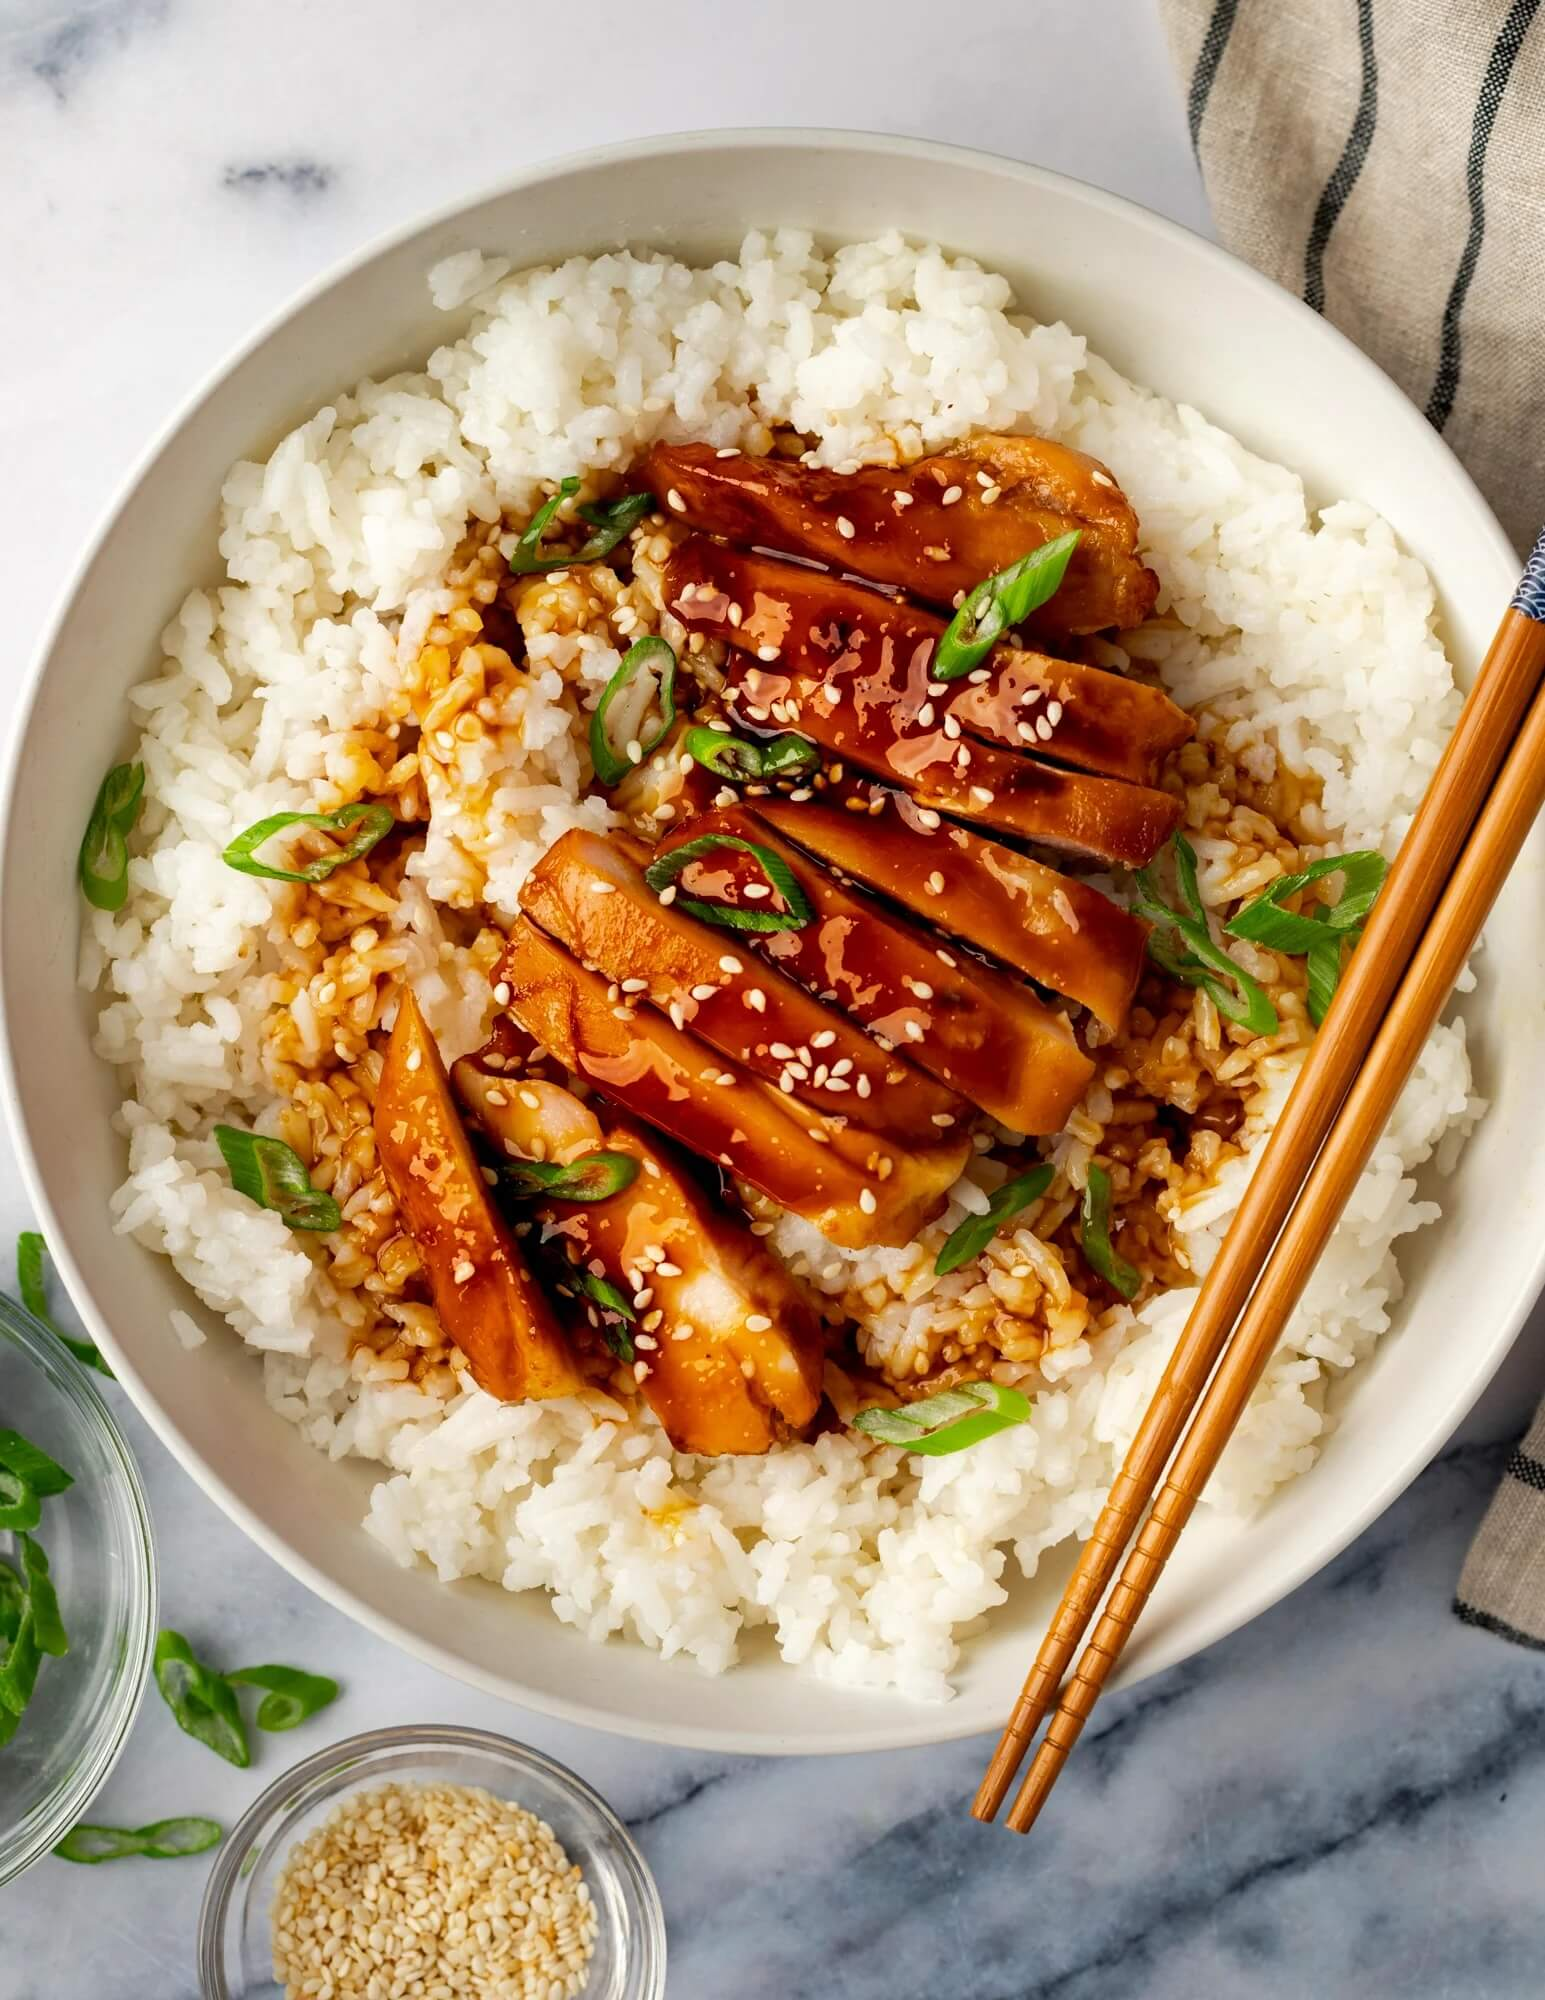

In [112]:
img = Image.open("chicken-teriyaki.jpg")
img

In [114]:
SYSTEM_PROMPT = """
You are an Expert Nutritionist and Food Scientist.

Your task is to analyze the provided image of a meal to extract nutritional information (Macros: Protein, Fat, Carbs, Calories).
The user will provide the **TOTAL WEIGHT** of the food in grams.

**Process:**
1. **Visual Decomposition:** Identify the visible ingredients.
2. **Ratio Estimation:** Estimate the percentage split of the total weight for each ingredient (e.g., if total is 400g, is it 200g rice and 200g chicken?).
3. **Macro Calculation:** Calculate the macros for each specific ingredient weight using standard nutritional data (USDA style).
4. **Aggregation:** Sum the values for the Total Macros.

**Rules:**
- **Strictly adhere to the user-provided Total Weight.** Do not estimate the total weight yourself; use the input.
- **Skip negligible items:** Do not list spices (salt, pepper), water, or very low-calorie garnishes (like a sprinkle of green onions) unless they constitute a significant portion of the weight.
- **Sauces count:** If a sauce is visible (like Teriyaki, Mayo, Oil), you MUST estimate its weight and include it, as these are calorie-dense.
"""

In [115]:
class NutritionalValues(BaseModel):
    """Macro-nutrient breakdown."""

    calories: int = Field(..., description="Total energy in kcal.")
    protein: float = Field(..., description="Protein content in grams.")
    carbs: float = Field(..., description="Total carbohydrates in grams.")
    fat: float = Field(..., description="Total fat in grams.")


class Ingredient(BaseModel):
    """Breakdown of a specific macro-dense ingredient."""

    name: str = Field(
        ...,
        description="Name of the ingredient (e.g., 'White Rice', 'Grilled Chicken Breast').",
    )
    estimated_weight_g: int = Field(
        ..., description="The estimated weight of this specific ingredient in grams."
    )
    macros: NutritionalValues = Field(
        ..., description="The calculated macros for this specific portion size."
    )


class DishAnalysis(BaseModel):
    """Final output for the food analysis."""

    dish_name: str = Field(
        ..., description="A short, descriptive name of the dish identified."
    )
    total_weight_g: int = Field(
        ..., description="The total weight input provided by the user."
    )
    total_macros: NutritionalValues = Field(
        ..., description="Aggregated macros for the entire dish."
    )
    ingredients: list[Ingredient] = Field(
        ...,
        description="List of main ingredients. Excludes spices and negligible low-cal garnishes.",
    )

In [116]:
generate_config = types.GenerateContentConfig(
    system_instruction=SYSTEM_PROMPT,
    response_mime_type="application/json",
    response_schema=DishAnalysis,
    temperature=0.0,
    seed=0,
)

In [117]:
total_weight = 450
user_prompt = (
    f"The total weight of this food is {total_weight} grams. Break down the macros."
)

In [120]:
parts = [
    types.Part.from_bytes(
        data=Path("chicken-teriyaki.jpg").read_bytes(), mime_type=JPG_MIME_TYPE
    ),
    types.Part.from_text(text=user_prompt),
]
contents = types.Content(role="user", parts=parts)

In [122]:
%%time
response = client.models.generate_content(
    model=MODEL_ID, contents=contents, config=generate_config
)

CPU times: user 26.9 ms, sys: 1.62 ms, total: 28.5 ms
Wall time: 13.6 s


In [123]:
pprint(response.usage_metadata.model_dump())

{'cache_tokens_details': None,
 'cached_content_token_count': None,
 'candidates_token_count': 334,
 'candidates_tokens_details': None,
 'prompt_token_count': 1389,
 'prompt_tokens_details': [{'modality': <MediaModality.IMAGE: 'IMAGE'>,
                            'token_count': 1102},
                           {'modality': <MediaModality.TEXT: 'TEXT'>,
                            'token_count': 287}],
 'thoughts_token_count': 1675,
 'tool_use_prompt_token_count': None,
 'tool_use_prompt_tokens_details': None,
 'total_token_count': 3398,
 'traffic_type': None}


In [124]:
result = response.parsed

In [125]:
pprint(result.model_dump())

{'dish_name': 'Chicken Teriyaki Bowl',
 'ingredients': [{'estimated_weight_g': 270,
                  'macros': {'calories': 351,
                             'carbs': 75.6,
                             'fat': 0.8,
                             'protein': 7.3},
                  'name': 'Cooked White Rice'},
                 {'estimated_weight_g': 130,
                  'macros': {'calories': 272,
                             'carbs': 0.0,
                             'fat': 14.3,
                             'protein': 33.8},
                  'name': 'Grilled Chicken Thigh'},
                 {'estimated_weight_g': 50,
                  'macros': {'calories': 90,
                             'carbs': 20.0,
                             'fat': 0.0,
                             'protein': 1.0},
                  'name': 'Teriyaki Sauce'}],
 'total_macros': {'calories': 713, 'carbs': 95.6, 'fat': 15.1, 'protein': 42.1},
 'total_weight_g': 450}


In [128]:
pprint([i.model_dump() for i in result.ingredients])

[{'estimated_weight_g': 270,
  'macros': {'calories': 351, 'carbs': 75.6, 'fat': 0.8, 'protein': 7.3},
  'name': 'Cooked White Rice'},
 {'estimated_weight_g': 130,
  'macros': {'calories': 272, 'carbs': 0.0, 'fat': 14.3, 'protein': 33.8},
  'name': 'Grilled Chicken Thigh'},
 {'estimated_weight_g': 50,
  'macros': {'calories': 90, 'carbs': 20.0, 'fat': 0.0, 'protein': 1.0},
  'name': 'Teriyaki Sauce'}]


In [130]:
ingredients_weight = sum([i.estimated_weight_g for i in result.ingredients])
assert ingredients_weight == total_weight

## References

- Resume: https://github.com/lgeurts/resume